In [1]:
import os
import pandas as pd
import pickle
from importlib import reload
import lime.lime_rdf
from rdflimeConfig import movieLocation
import logging 

logging.basicConfig(level=logging.WARN)

movieFull = pd.read_csv(os.path.join(movieLocation, "movies_fixed.tsv"), sep="\t")
movies = [movie.DBpedia_URI for _, movie in movieFull.iterrows()]

In [5]:
reload(lime.lime_rdf)
from lime.lime_rdf import LimeRdfExplainer

with open(os.path.join(movieLocation, "transformers", "rdf2vec_transformer_cbow_200"), "rb") as file:
    rdf2vec_transformer = pickle.load(file)

with open(os.path.join(movieLocation, "classifiers", "svc_100_cbow_200"), "rb") as file:
    clf = pickle.load(file)

explainer = LimeRdfExplainer(
    transformer=rdf2vec_transformer, 
    entities=movies,
    class_names=clf.classes_,
    kernel=None,
    kernel_width=25,
    verbose=False,
    feature_selection="auto",
    random_state=42
)


explained_entity_id = 274  # 0-400 -> test data
explained_entity_uri = movies[explained_entity_id]
prediction = clf.predict_proba([rdf2vec_transformer._embeddings[explained_entity_id]])


print("Explaining", explained_entity_uri)
print("Original prediction:", prediction, " / ".join(clf.classes_))
print("True class:", movieFull.iloc[explained_entity_id].label)

data, probabilities, distances, explanation = explainer.explain_instance(
    entity=explained_entity_uri, 
    classifier_fn=clf.predict_proba,
    num_features=50,
    num_samples=5000,
    allow_triple_addition=False,
    allow_triple_subtraction=True,
    max_changed_triples=20,
    change_count_fixed=True,
    use_w2v_freeze=True,
    center_correction=False,
    single_run=False,
    train_with_all=False,
    distance_metric="cosine",
    model_regressor=None,
    short_uris=False
)

Explaining http://dbpedia.org/resource/Scooby-Doo_2:_Monsters_Unleashed
Original prediction: [[0.100695 0.899305]] bad / good
True class: bad


Preparing perturbed walks: 100%|██████████| 5000/5000 [01:04<00:00, 78.05it/s]


Average remaining walks per artificial entity (from 484): 375.8628


Training perturbed W2V embeddings: 100%|██████████| 5000/5000 [07:22<00:00, 11.31it/s]


Got data, labels, and distances


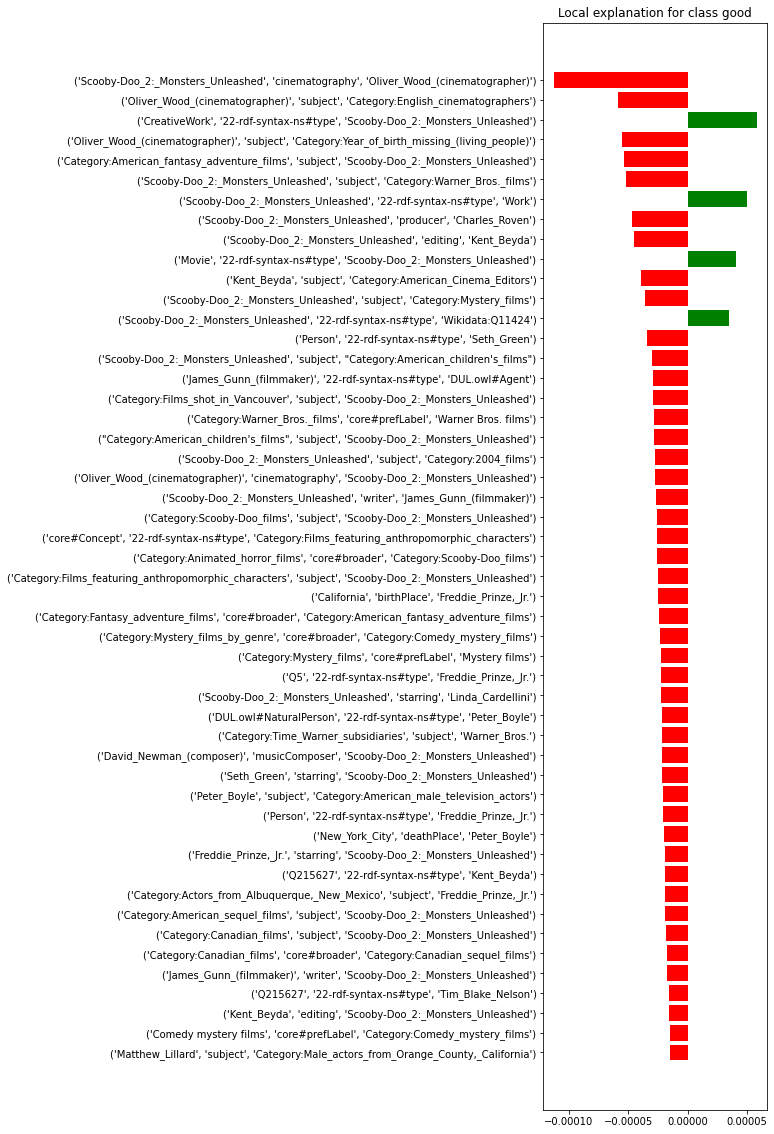

In [6]:
figsize = (4, .4*len(explanation.as_list()))

explanation.domain_mapper.short_uris=True
fig = explanation.as_pyplot_figure(figsize=figsize)
explanation.domain_mapper.short_uris=False


<AxesSubplot:>

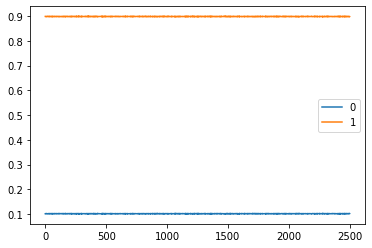

In [13]:
pd.DataFrame(probabilities).plot()

# thesis: show plot with/without single_run

In [141]:
explanation.domain_mapper.short_uris=True
with open("test.html", "w") as f:
    f.write(explanation.as_html())
    explanation.domain_mapper.short_uris=False

In [14]:
iw = explainer.indexed_walks

top_triples = explanation.as_list()[:15]

relevant_walks = []
for triple in top_triples:
    for w in iw.walks(explained_entity_uri, tuple(triple[0])):
        
        entity_pos = w.index(explained_entity_uri)

        for i in range(2, len(w)):
            if w[i-2] == triple[0][0] and w[i-1] == triple[0][1] and w[i] == triple[0][2]:
                triple_start_pos = i-2
                triple_end_pos = i
        
        from_pos = min(entity_pos, triple_start_pos)
        to_pos = max(entity_pos, triple_end_pos)

        relevant_walks.append(w[from_pos:to_pos+1])



relevant_triples = iw.walks_as_triples(relevant_walks)

In [15]:
edges = []
labels = {}

min_edge_width = 0.25
max_edge_width = 8
max_score = max([abs(exp[1]) for exp in top_triples])

uri_trimmer = lambda uri: uri.split("/")[-1].split("#")[-1].replace(":", "_")
triple_trimmer = lambda triple: (uri_trimmer(triple[0]), uri_trimmer(triple[1]), uri_trimmer(triple[2]))

for rt in relevant_triples:
    score = next((exp[1] for exp in top_triples if rt==exp[0]), None)
    
    if score:
        # score *= -1
        color = "green" if score > 0 else "red"
        width = max(abs(score)/max_score*max_edge_width, min_edge_width)
    else:
        color = "blue"
        width = min_edge_width
        #print(rt, score)

    rt = triple_trimmer(rt)
    edge = (rt[0], rt[2], {"width": width, "color": color})
    
    label = rt[1]
    if score: label += f" ({round(width/max_edge_width, 2)})"

    edges.append(edge)
    
    labels[(edge[0],edge[1])] = label
    


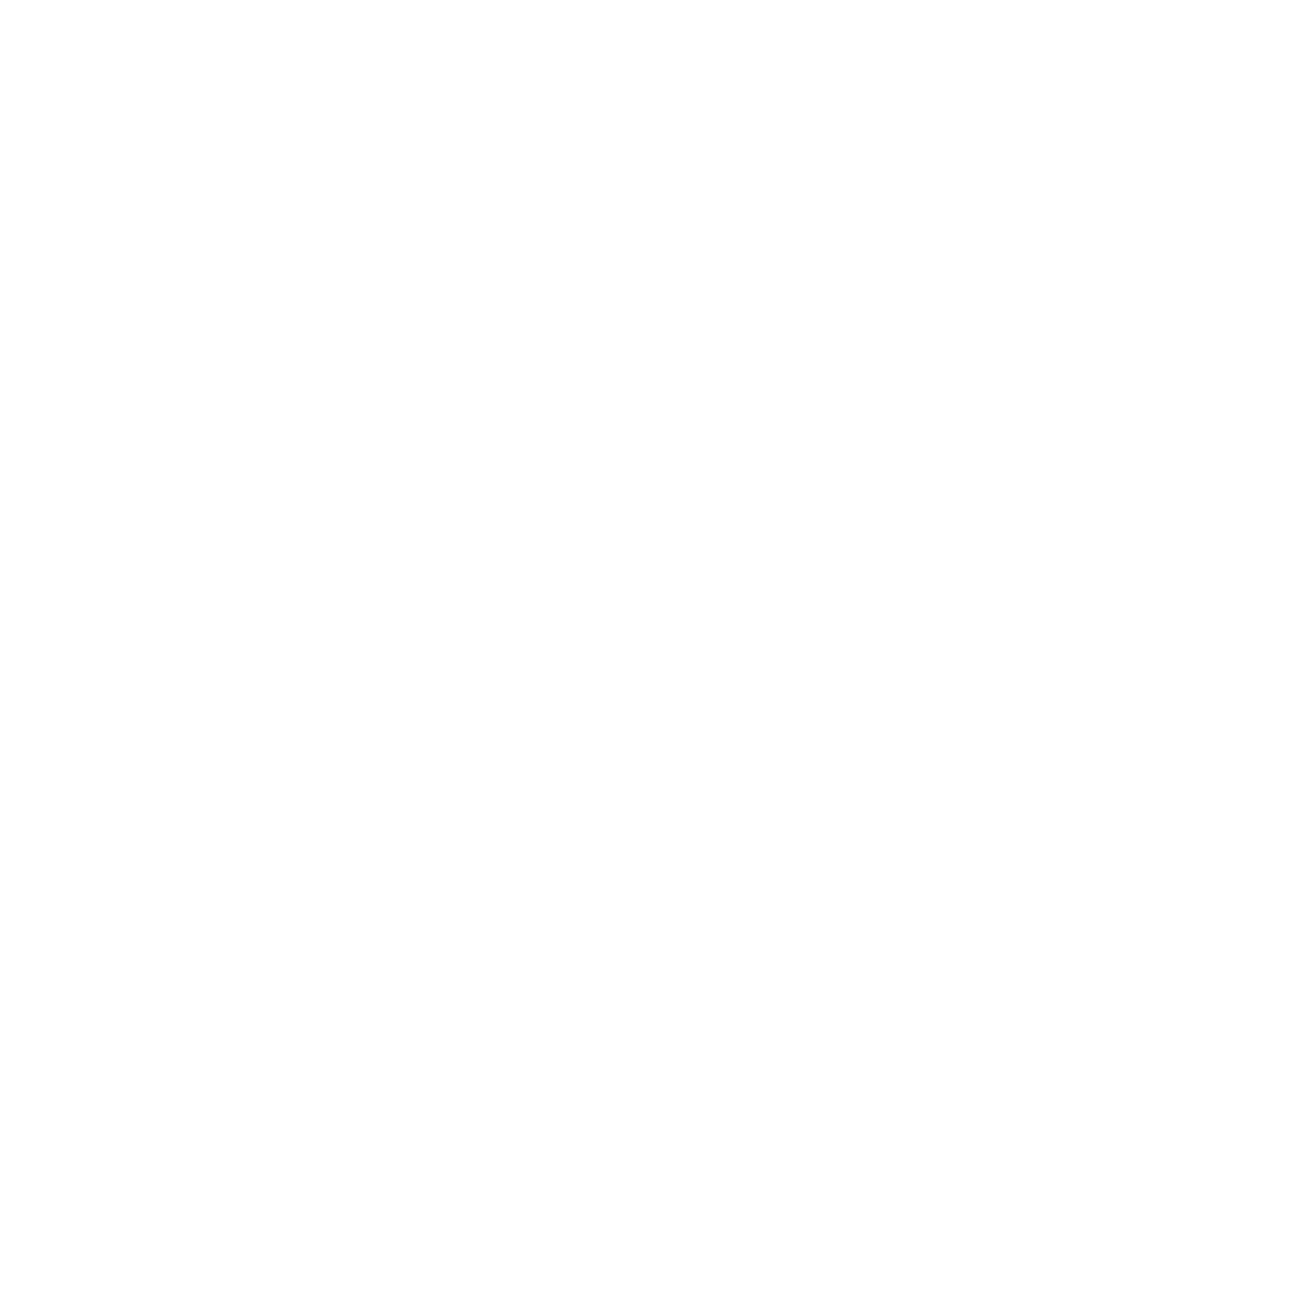

In [16]:
import matplotlib.pyplot as plt
import networkx as nx
from math import sqrt


G = nx.DiGraph()
G.add_edges_from(edges)
#pos = nx.spring_layout(G, k=1.25/sqrt(len(G.nodes())), seed=42, iterations=35)
pos = nx.nx_pydot.graphviz_layout(G, prog="neato")
plt.figure(figsize=(18,18))
nx.draw(
    G, pos,
    node_size=500, node_color='lightblue', alpha=0.9,
    labels={node: node for node in G.nodes()},
    arrowstyle='->',
    width=[G[u][v]['width'] for u,v in G.edges()],
    edge_color=[G[u][v]['color'] for u,v in G.edges()],
)


_ = nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels=labels,
    font_color='black',
)

# plt.savefig("green_lantern.pdf")

x = nx.nx_pydot.to_pydot(G)

# Bug: node labels with :

In [17]:
def check_explanations():
    exp_list = explanation.as_list()[:25]

    for exp in exp_list:
        triple = exp[0]
        if "_" in triple: continue
        modified_walks = explainer.get_perturbed_walks(explained_entity_uri, added_triples=[], removed_triples=[triple])
        embedding = explainer.get_perturbed_embedding(explained_entity_uri, modified_walks)
        new_prediction = clf.predict_proba([embedding])
        print( (new_prediction[0][1] - prediction[0][1]) / exp[1], triple )

In [148]:
#
# Explained Change / Real Change
#
# +0.5 / +0.5 
# +
#


In [18]:
check_explanations()

### Experiments

In [18]:
from pyvis.network import Network
nt = Network('500px', '500px')
nt.from_nx(G)
nt.show("nx.html")

In [ ]:
wv_old = explainer.old_transformer.embedder._model.wv
wv_new = explainer.transformer.embedder._model.wv
def embedding(URI, new):
    wv = wv_new if new else wv_old
    return wv.get_vector(URI)

In [ ]:
wv_old.most_similar(explainer.new_embeddings[150])

In [ ]:
# Check if the movie embedding itself drifted
all(embedding(explained_entity_uri, new=True) == embedding(explained_entity_uri, new=False))

In [ ]:
for walk in explainer.indexedWalks.walks(e):
    for step in walk:
        if not step in changed and not step == e:
            print(step)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
# Reduce the dimensions of entity embeddings to represent them in a 2D plane.
X_tsne = TSNE(random_state=42).fit_transform([wv_old[explained_entity_uri]] + explainer.new_embeddings)

labels = explainer.old_transformer._entities + list(range(len(explainer.new_embeddings)))
labels = [explained_entity_uri] + list(range(len(explainer.new_embeddings)))

#colors = list(map(lambda e: "#00ff00" if movieTest[movieTest.DBpedia_URI==e].iloc[0].label == "good" else "#ff0000", transformer._entities[1600:]))
#sizes = list(map(lambda e: abs(50-movieTest[movieTest.DBpedia_URI==e].iloc[0].rating)**2, transformer._entities[1600:]))
sizes = list(map(lambda l: 100**2 if l == explained_entity_uri or l == 0 else 25**2, labels))

# Ploy the embeddings of entities in a 2D plane, annotating them.
f = plt.figure(figsize=(200, 80))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=sizes)#, c=colors, s=sizes)

for x, y, t in zip(X_tsne[:, 0], X_tsne[:, 1], labels):
    if type(t) == str and "http" in t: t = t.split("/")[-1]
    plt.annotate(t, (x, y))

# Display the graph with a title, removing the axes for better readability.
plt.title("pyRDF2Vec", fontsize=4)
plt.axis("off")
plt.show()

#f.savefig("figure.pdf", bbox_inches='tight')


In [ ]:
unique_triples = len(explainer.indexed_walks.walks_as_triples(explainer.indexed_walks.walks(explained_entity_uri)))
unique_triples

In [ ]:
keanu = embedding("http://dbpedia.org/resource/Keanu_Reeves", new=True)
matrix = embedding("http://dbpedia.org/resource/The_Matrix", new=True)
wv_new.most_similar(matrix-keanu, topn=len(wv_new))[0]
wv_new.most_similar(positive=["http://dbpedia.org/resource/The_Matrix"], negative=["http://dbpedia.org/resource/Keanu_Reeves"])

In [35]:
movie_search = lambda query: [(i,x) for i,x in enumerate(movies) if query.lower() in x.lower()]
movie_search("star")

[(7, 'http://dbpedia.org/resource/Star_Wars_(film)'),
 (106, 'http://dbpedia.org/resource/Star_Trek_II:_The_Wrath_of_Khan'),
 (145, 'http://dbpedia.org/resource/Star_Trek_IV:_The_Voyage_Home'),
 (496, 'http://dbpedia.org/resource/Position_Among_the_Stars'),
 (597, 'http://dbpedia.org/resource/Starting_Out_in_the_Evening'),
 (607, 'http://dbpedia.org/resource/Lone_Star_(1996_film)'),
 (671, 'http://dbpedia.org/resource/Startup.com'),
 (823, 'http://dbpedia.org/resource/Star_Trek:_First_Contact'),
 (1026, 'http://dbpedia.org/resource/Star_Trek_VI:_The_Undiscovered_Country'),
 (1068, 'http://dbpedia.org/resource/Star_Trek:_Insurrection'),
 (1375, 'http://dbpedia.org/resource/Dickie_Roberts:_Former_Child_Star'),
 (1399, 'http://dbpedia.org/resource/Stardom'),
 (1450, 'http://dbpedia.org/resource/Star_Wars:_The_Clone_Wars_(film)'),
 (1989, 'http://dbpedia.org/resource/Bucky_Larson:_Born_to_Be_a_Star')]

In [ ]:
movieFull[200:220]

In [ ]:
from concurrent.futures import ProcessPoolExecutor

def xm(i): 
    print(i)

with ProcessPoolExecutor() as executor:
    executor.map(xm, [1,2,3])

In [19]:
for i in range(155):

    reload(lime.lime_rdf)
    from lime.lime_rdf import LimeRdfExplainer

    with open(os.path.join(movieLocation, "transformers", "rdf2vec_transformer_cbow_200"), "rb") as file:
        rdf2vec_transformer = pickle.load(file)

    with open(os.path.join(movieLocation, "classifiers", "svc_100_cbow_200"), "rb") as file:
        clf = pickle.load(file)

    explainer = LimeRdfExplainer(
        transformer=rdf2vec_transformer, 
        entities=movies,
        class_names=clf.classes_,
        kernel=None,
        kernel_width=25,
        verbose=False,
        feature_selection="auto",
        random_state=42
    )


    explained_entity_id = i  # 0-400 -> test data
    explained_entity_uri = movies[explained_entity_id]
    prediction = clf.predict_proba([rdf2vec_transformer._embeddings[explained_entity_id]])


    print("Explaining", explained_entity_uri)
    print("Original prediction:", prediction, " / ".join(clf.classes_))
    print("True class:", movieFull.iloc[explained_entity_id].label)

    data, probabilities, distances, explanation = explainer.explain_instance(
        entity=explained_entity_uri, 
        classifier_fn=clf.predict_proba,
        num_features=50,
        num_samples=5000,
        allow_triple_addition=False,
        allow_triple_subtraction=True,
        max_changed_triples=20,
        change_count_fixed=True,
        use_w2v_freeze=True,
        center_correction=False,
        single_run=False,
        train_with_all=False,
        distance_metric="cosine",
        model_regressor=None,
        short_uris=False
    )

    with open(f"explanation-{i}", "wb") as f:
        pickle.dump([explanation, probabilities], f)

Explaining http://dbpedia.org/resource/4_Months,_3_Weeks_and_2_Days
Original prediction: [[0.00673385 0.99326615]] bad / good
True class: good


Preparing perturbed walks: 100%|██████████| 5000/5000 [00:57<00:00, 86.81it/s]


Average remaining walks per artificial entity (from 484): 327.6906


Training perturbed W2V embeddings: 100%|██████████| 5000/5000 [06:39<00:00, 12.51it/s]


Got data, labels, and distances
Explaining http://dbpedia.org/resource/Ratatouille_(film)
Original prediction: [[0.02784811 0.97215189]] bad / good
True class: good


Preparing perturbed walks: 100%|██████████| 5000/5000 [01:02<00:00, 80.48it/s]


Average remaining walks per artificial entity (from 484): 382.3828


Training perturbed W2V embeddings: 100%|██████████| 5000/5000 [06:41<00:00, 12.44it/s]


Got data, labels, and distances
Explaining http://dbpedia.org/resource/Killer_of_Sheep
Original prediction: [[0.99646615 0.00353385]] bad / good
True class: good


Preparing perturbed walks: 100%|██████████| 5000/5000 [00:52<00:00, 94.54it/s]


Average remaining walks per artificial entity (from 484): 287.1698


Training perturbed W2V embeddings: 100%|██████████| 5000/5000 [05:10<00:00, 16.08it/s]


Got data, labels, and distances
Explaining http://dbpedia.org/resource/Sideways
Original prediction: [[0.01252449 0.98747551]] bad / good
True class: good


Preparing perturbed walks: 100%|██████████| 5000/5000 [01:01<00:00, 81.74it/s]


Average remaining walks per artificial entity (from 484): 370.9466


Training perturbed W2V embeddings: 100%|██████████| 5000/5000 [6:56:27<00:00,  5.00s/it]       


Got data, labels, and distances
Explaining http://dbpedia.org/resource/Sita_Sings_the_Blues
Original prediction: [[0.01887515 0.98112485]] bad / good
True class: good


Preparing perturbed walks: 100%|██████████| 5000/5000 [00:56<00:00, 89.26it/s]


Average remaining walks per artificial entity (from 484): 297.9878


Training perturbed W2V embeddings: 100%|██████████| 5000/5000 [06:11<00:00, 13.45it/s]


Got data, labels, and distances
Explaining http://dbpedia.org/resource/The_Hurt_Locker
Original prediction: [[0.93919414 0.06080586]] bad / good
True class: good


Preparing perturbed walks: 100%|██████████| 5000/5000 [01:04<00:00, 77.73it/s]


Average remaining walks per artificial entity (from 484): 379.2632


Training perturbed W2V embeddings: 100%|██████████| 5000/5000 [07:44<00:00, 10.76it/s]


Got data, labels, and distances
Explaining http://dbpedia.org/resource/Close_Encounters_of_the_Third_Kind
Original prediction: [[0.02181897 0.97818103]] bad / good
True class: good


Preparing perturbed walks: 100%|██████████| 5000/5000 [01:02<00:00, 79.94it/s]


Average remaining walks per artificial entity (from 484): 370.5642


Training perturbed W2V embeddings: 100%|██████████| 5000/5000 [07:29<00:00, 11.13it/s]


Got data, labels, and distances
Explaining http://dbpedia.org/resource/Star_Wars_(film)
Original prediction: [[0.03639992 0.96360008]] bad / good
True class: good


Preparing perturbed walks: 100%|██████████| 5000/5000 [01:02<00:00, 79.39it/s]


Average remaining walks per artificial entity (from 484): 368.1126


Training perturbed W2V embeddings: 100%|██████████| 5000/5000 [07:20<00:00, 11.35it/s]


Got data, labels, and distances
Explaining http://dbpedia.org/resource/Moolaadé
Original prediction: [[0.2210593 0.7789407]] bad / good
True class: good


Preparing perturbed walks: 100%|██████████| 5000/5000 [00:55<00:00, 90.45it/s]


Average remaining walks per artificial entity (from 484): 332.6018


Training perturbed W2V embeddings: 100%|██████████| 5000/5000 [06:26<00:00, 12.95it/s]


Got data, labels, and distances
Explaining http://dbpedia.org/resource/A_Prophet
Original prediction: [[0.0203505 0.9796495]] bad / good
True class: good


Preparing perturbed walks: 100%|██████████| 5000/5000 [01:00<00:00, 83.30it/s]


Average remaining walks per artificial entity (from 484): 353.8298


Training perturbed W2V embeddings: 100%|██████████| 5000/5000 [08:02<00:00, 10.37it/s]


Got data, labels, and distances
Explaining http://dbpedia.org/resource/Before_Sunset
Original prediction: [[0.32108033 0.67891967]] bad / good
True class: good


Preparing perturbed walks: 100%|██████████| 5000/5000 [00:59<00:00, 83.40it/s]


Average remaining walks per artificial entity (from 484): 353.5646


Training perturbed W2V embeddings: 100%|██████████| 5000/5000 [07:05<00:00, 11.74it/s]


Got data, labels, and distances
Explaining http://dbpedia.org/resource/Capturing_the_Friedmans
Original prediction: [[0.04615446 0.95384554]] bad / good
True class: good


Preparing perturbed walks: 100%|██████████| 5000/5000 [00:56<00:00, 88.26it/s]


Average remaining walks per artificial entity (from 484): 299.5506


Training perturbed W2V embeddings: 100%|██████████| 5000/5000 [06:26<00:00, 12.93it/s]


Got data, labels, and distances
Explaining http://dbpedia.org/resource/Finding_Nemo
Original prediction: [[0.15558284 0.84441716]] bad / good
True class: good


Preparing perturbed walks: 100%|██████████| 5000/5000 [01:02<00:00, 79.61it/s]


Average remaining walks per artificial entity (from 484): 376.9248


Training perturbed W2V embeddings: 100%|██████████| 5000/5000 [08:01<00:00, 10.39it/s]


Got data, labels, and distances
Explaining http://dbpedia.org/resource/Hannah_and_Her_Sisters
Original prediction: [[0.0275146 0.9724854]] bad / good
True class: good


Preparing perturbed walks: 100%|██████████| 5000/5000 [01:03<00:00, 79.24it/s]


Average remaining walks per artificial entity (from 484): 377.0598


Training perturbed W2V embeddings: 100%|██████████| 5000/5000 [07:34<00:00, 11.01it/s]


Got data, labels, and distances
Explaining http://dbpedia.org/resource/Raiders_of_the_Lost_Ark
Original prediction: [[0.00352684 0.99647316]] bad / good
True class: good


Preparing perturbed walks: 100%|██████████| 5000/5000 [01:04<00:00, 77.60it/s]


Average remaining walks per artificial entity (from 484): 376.5092


Training perturbed W2V embeddings: 100%|██████████| 5000/5000 [07:59<00:00, 10.42it/s]


Got data, labels, and distances
Explaining http://dbpedia.org/resource/Goodbye_Solo
Original prediction: [[0.31254864 0.68745136]] bad / good
True class: good


Preparing perturbed walks: 100%|██████████| 5000/5000 [00:55<00:00, 89.33it/s]


Average remaining walks per artificial entity (from 484): 301.464


Training perturbed W2V embeddings: 100%|██████████| 5000/5000 [06:24<00:00, 12.99it/s]


Got data, labels, and distances
Explaining http://dbpedia.org/resource/Letters_from_Iwo_Jima
Original prediction: [[0.5 0.5]] bad / good
True class: good


Preparing perturbed walks: 100%|██████████| 5000/5000 [01:02<00:00, 79.57it/s]


Average remaining walks per artificial entity (from 484): 379.5912


Training perturbed W2V embeddings: 100%|██████████| 5000/5000 [07:50<00:00, 10.62it/s]


Got data, labels, and distances
Explaining http://dbpedia.org/resource/Chicken_Run
Original prediction: [[0.11090778 0.88909222]] bad / good
True class: good


Preparing perturbed walks: 100%|██████████| 5000/5000 [01:03<00:00, 78.31it/s]


Average remaining walks per artificial entity (from 484): 381.5544


Training perturbed W2V embeddings: 100%|██████████| 5000/5000 [07:57<00:00, 10.48it/s]


Got data, labels, and distances
Explaining http://dbpedia.org/resource/Toy_Story_2
Original prediction: [[0.12142543 0.87857457]] bad / good
True class: good


Preparing perturbed walks: 100%|██████████| 5000/5000 [01:02<00:00, 80.64it/s]


Average remaining walks per artificial entity (from 484): 353.5434


Training perturbed W2V embeddings: 100%|██████████| 5000/5000 [06:54<00:00, 12.06it/s]


Got data, labels, and distances
Explaining http://dbpedia.org/resource/All_About_My_Mother
Original prediction: [[8.43849354e-06 9.99991562e-01]] bad / good
True class: good


Preparing perturbed walks: 100%|██████████| 5000/5000 [01:05<00:00, 76.57it/s]


Average remaining walks per artificial entity (from 484): 378.9336


Training perturbed W2V embeddings:  73%|███████▎  | 3631/5000 [06:01<02:16, 10.05it/s]


KeyboardInterrupt: 